#  Lesson 3. Classify and Plot Raster Data in Python

Learning Objectives
- Explore a raster and produce histograms to help define appropriate raster break points for classification.
- Reclassify a raster dataset in Python using a set of defined values and np.digitize.

#### Manually Reclassify Raster Data
In this lesson, you will learn how to reclassify a raster dataset in Python. When you reclassify a raster, you create a new raster object / file that can be exported and shared with colleagues and / or open in other tools such as QGIS.

In that raster, each pixel is mapped to a new value based on some approach. This approach can vary depending upon your science question.

## Raster Classification Steps
You can break your raster processing workflow into several steps as follows:

- **Data import / cleanup**: load and “clean” the data. This includes cropping, removing with nodata values


- **Data Exploration:** understand the range and distribution of values in your data. This may involve plotting histograms and scatter plots to determine what classes are appropriate for our data


- **Reclassify the Data:** Once you understand the distribution of your data, you are ready to reclassify. There are statistical and non-statistical approaches to reclassification. Here you will learn how to manually reclassify a raster using bins that you define in your data exploration step.

In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
import seaborn as sns
sns.set(font_scale=1.5, style="whitegrid")

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

To begin, open the lidar_chm.tif file that you created in the previous lesson, or recreate it using the code below.

In [2]:
# Define relative paths to DTM and DSM files
dtm_path = os.path.join("colorado-flood",
                        "spatial",
                        "boulder-leehill-rd",
                        "pre-flood",
                        "lidar",
                        "pre_DTM.tif")

dsm_path = os.path.join("colorado-flood",
                        "spatial",
                        "boulder-leehill-rd",
                        "pre-flood",
                        "lidar",
                        "pre_DSM.tif")

# Open DTM and DSM files
pre_lidar_dtm = rxr.open_rasterio(dtm_path, masked=True).squeeze()
pre_lidar_dsm = rxr.open_rasterio(dsm_path, masked=True).squeeze()

# Create canopy height model (CHM)
pre_lidar_chm = pre_lidar_dsm - pre_lidar_dtm
pre_lidar_chm

<xarray.DataArray (y: 2000, x: 4000)>
array([[       nan,        nan,        nan, ..., 0.        , 0.17004395,
        0.960083  ],
       [       nan,        nan,        nan, ..., 0.        , 0.09008789,
        1.6400146 ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.07995605],
       ...,
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)
Coordinates:
    band         int32 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int32 0

#### What Classification Values to Use?
There are many different approaches to classification. Some use highly sophisticated spatial algorithms that identify patterns in the data that can in turn be used to classify particular pixels into particular “classes”.

In this case, you are simply going to create the classes manually using the range of quantitative values found in our data.

Assuming that our data represent trees (though you know there are likely some buildings in the data), classify your raster into 3 classes:

- Short trees
- Medium trees
- Tall trees

To perform this classification, you need to understand which values represent short trees vs medium trees vs tall trees in your raster. This is where histograms can be extremely useful.

Start by looking at the min and max values in your CHM.



In [3]:
# View min and max values in the data
print('CHM min value:', np.nanmin(pre_lidar_chm))
print('CHM max value:', np.nanmax(pre_lidar_chm))

CHM min value: 0.0
CHM max value: 26.930054


#### Get to Know Raster Summary Statistics
Get to know your data by looking at a histogram. A histogram quantifies the distribution of values found in your data

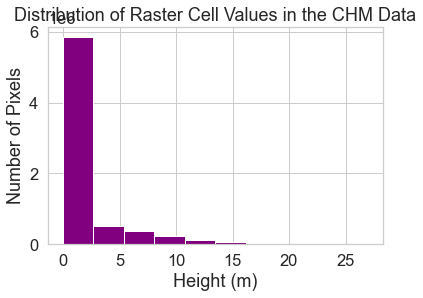

In [4]:
f, ax = plt.subplots()
pre_lidar_chm.plot.hist(color="purple")
ax.set(title="Distribution of Raster Cell Values in the CHM Data",
       xlabel="Height (m)",
       ylabel="Number of Pixels")
plt.show()

You can look at the values that Python used to draw your histogram, too.

To do this, you can collect the outputs that are returned when you call np.histogram. This consists of two things:

- counts, which represents the number of items in each bin
- bins, which represents the edges of the bins (there will be one extra item in bins compared to counts)

Each **bin represents a bar on your histogram plot**. Each bar represents the frequency or number of pixels that have a value within that bin.

Notice that you have adjusted the xlim and ylim to zoom into the region of the histogram that you are interested in exploring; however, the values did not actually change.

#### Histogram with Custom Breaks
Customize your histogram with breaks that you think might make sense as breaks to use for your raster map.

In the example below, breaks are added in 5 meter increments using the bins = argument.

#### bins=[0, 5, 10, 15, 20, 30]

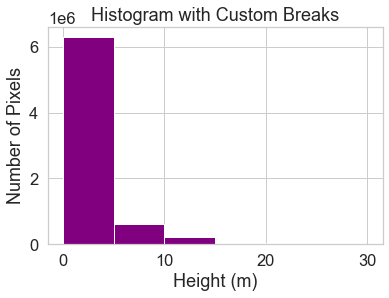

In [5]:
# Histogram with custom breaks
f, ax = plt.subplots()
pre_lidar_chm.plot.hist(color="purple",
                        bins=[0, 5, 10, 15, 20, 30])
ax.set(title="Histogram with Custom Breaks",
       xlabel="Height (m)",
       ylabel="Number of Pixels")

plt.show()

You also know you want to create bins for short, medium and tall trees, so experiment with those bins as well.

Below following breaks are used:

- 0 - 2 = no trees
- 2 - 7 = short trees
- 7 - 12 = medium trees
- More than 12 = tall trees

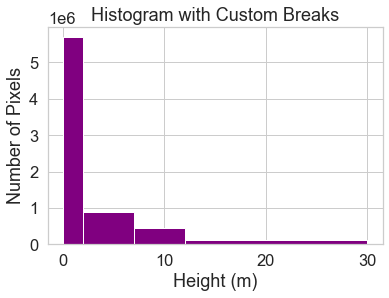

In [6]:
# Histogram with custom breaks
f, ax = plt.subplots()

pre_lidar_chm.plot.hist(
    color='purple',
    bins=[0, 2, 7, 12, 30])
ax.set(title="Histogram with Custom Breaks",
       xlabel="Height (m)",
       ylabel="Number of Pixels")

plt.show()

### Map Raster Values to New Values
To reclassify your raster, first you need to create a reclassification matrix.

This matrix MAPS a range of values to a new defined value. You will use this matrix to create a classified canopy height model where you designate short, medium and tall trees.

The newly defined values will be as follows:

- No trees: (0m - 2m tall) = NA
- Short trees: (2m - 7m tall) = 1
- Medium trees: (7m - 12m tall) = 2
- Tall trees: (> 12m tall) = 3

Notice in the list above that you set cells with a value between 0 and 2 meters to NA or nodata value. 

Notice in the matrix below that you use Inf to represent the largest or max value found in the raster. So our assignment is as follows:

- 0 - 2 meters -> 1
- 2 - 7 meters -> 2 (short trees)
- 7 - 12 meters -> 3 (medium trees)
- More than 12 or 12 - Inf -> 4 (tall trees)

## create the matrix

## np.digitize
Numpy has a function called digitize that is useful for classifying the values in an array. It is similar to how histogram works, because it categorizes datapoints into bins. However, unlike histogram, it doesn’t aggregate/count the number of values within each bin.

Instead, digitize will replace each datapoint with an integer corresponding to which bin it belongs to. You can use this to determine which datapoints fall within certain ranges.

When you use np.digitize, the bins that you create work as follows:

- The starting value by default is included in each bin. The ending value of the bin is not and will be the beginning of the next bin. You can add the argument right = True if you want the second value in the bin to be included but not the first.
- Any values BELOW the bins as defined will be assigned a 0. Any values ABOVE the highest value in your bins will be assigned the next value available. Thus, if you have:

#### class_bins = [0, 2, 7, 12, 30]

#### Any values that are equal to 30 or larger will be assigned a value of 5. Any values that are < 0 will be assigned a value of 0.



In [10]:
# Check nodata value for your array
print(pre_lidar_chm.rio.nodata)

None


Below you define 4 bins. However, you end up with a fifth class == 0 which represents values smaller than 0 which is the minimum value in your chm.

These values < 0 come from the numpy mask fill value which you can see identified above this text.

In [11]:
data_min_value = np.nanmin(pre_lidar_chm)
data_max_value = np.nanmax(pre_lidar_chm)
print(data_min_value, data_max_value)

0.0 26.930054


In [12]:
class_bins = [-np.inf, 2, 7, 12, np.inf]
class_bins

[-inf, 2, 7, 12, inf]

In [13]:
pre_lidar_chm_class = xr.apply_ufunc(np.digitize,
                                     pre_lidar_chm,
                                     class_bins)

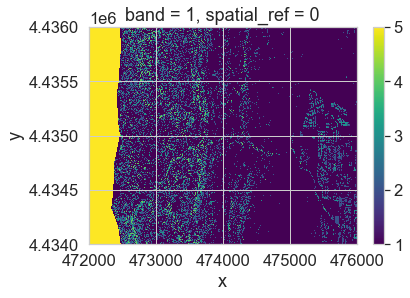

In [17]:
# Values of 5 represent missing data
im = pre_lidar_chm_class.plot.imshow()
ax.set_axis_off()

After running the classification, you have one extra class. This class - the first class - is your missing data value. Your classified array output is also a regular (not a masked) array.

You can **reassign the first class in your data to a mask using xarray .where().**

In [19]:
# Mask out values not equalt to 5
pre_lidar_chm_class_ma = pre_lidar_chm_class.where(pre_lidar_chm_class != 5)
pre_lidar_chm_class_ma

<xarray.DataArray (y: 2000, x: 4000)>
array([[nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.]])
Coordinates:
    band         int32 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int32 0

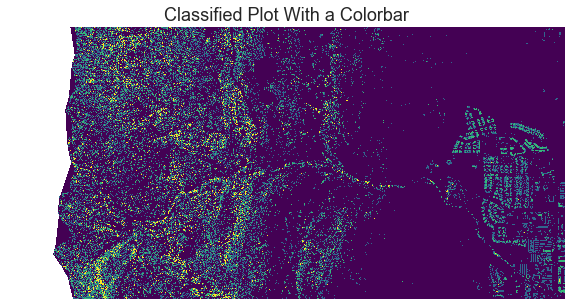

In [26]:
# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10,5))
pre_lidar_chm_class_ma.plot.imshow(# Turn off colorbar
                                        add_colorbar=False)
ax.set(title="Classified Plot With a Colorbar")

ax.set_axis_off()
plt.show()

Below the raster is plotted with slightly improved colors

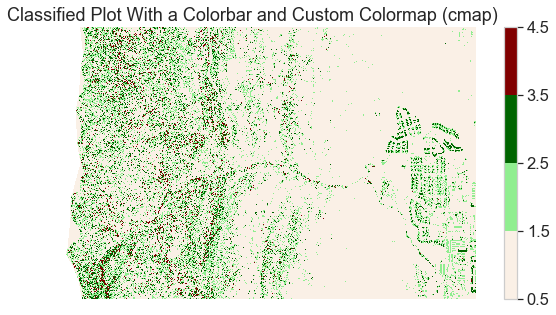

In [21]:
# Plot data using nicer colors
colors = ['linen', 'lightgreen', 'darkgreen', 'maroon']
class_bins = [.5, 1.5, 2.5, 3.5, 4.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 5))
pre_lidar_chm_class_ma.plot.imshow(cmap=cmap,
                                   norm=norm)
ax.set(title="Classified Plot With a Colorbar and Custom Colormap (cmap)")
ax.set_axis_off()
plt.show()


In [23]:
help(norm)

Help on BoundaryNorm in module matplotlib.colors object:

class BoundaryNorm(Normalize)
 |  BoundaryNorm(boundaries, ncolors, clip=False, *, extend='neither')
 |  
 |  Generate a colormap index based on discrete intervals.
 |  
 |  Unlike `Normalize` or `LogNorm`, `BoundaryNorm` maps values to integers
 |  instead of to the interval 0-1.
 |  
 |  Mapping to the 0-1 interval could have been done via piece-wise linear
 |  interpolation, but using integers seems simpler, and reduces the number of
 |  conversions back and forth between integer and floating point.
 |  
 |  Method resolution order:
 |      BoundaryNorm
 |      Normalize
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, value, clip=None)
 |      Normalize *value* data in the ``[vmin, vmax]`` interval into the
 |      ``[0.0, 1.0]`` interval and return it.
 |      
 |      Parameters
 |      ----------
 |      value
 |          Data to normalize.
 |      clip : bool
 |          If ``None``, default

## Add a Custom Legend to Your Plot with EarthPy
The plot looks OK but the legend does not represent the data well. The legend is continuous - with a range between 1.0 and 4.0 However, you want to plot the data using discrete bins.

Given you have discrete values, you can create a custom legend with the four categories that you created in your classification matrix.

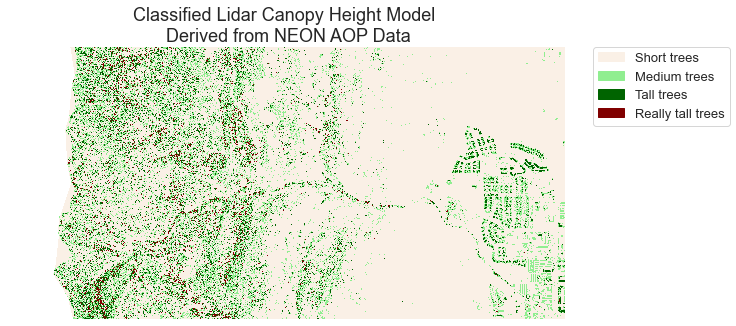

In [25]:
# Create a list of labels to use for your legend
height_class_labels = ["Short trees",
                       "Medium trees",
                       "Tall trees",
                       "Really tall trees"]

# Plot data using nicer colors
colors = ['linen', 'lightgreen', 'darkgreen', 'maroon']
class_bins = [.5, 1.5, 2.5, 3.5, 4.5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))
# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 5))
im = pre_lidar_chm_class_ma.plot.imshow(cmap=cmap,
                                        norm=norm,
                                        # Turn off colorbar
                                        add_colorbar=False)

# Add legend using earthpy
ep.draw_legend(im,
               titles=height_class_labels)
ax.set(title="Classified Lidar Canopy Height Model \n Derived from NEON AOP Data")
ax.set_axis_off()
plt.show()

## Optional Challenge: Plot Change Over Time

Create a classified raster map that shows positive and negative change in the canopy height model before and after the flood. To do this you will need to calculate the difference between two canopy height models.

In [27]:
# Define relative paths to DTM and DSM files
dtm_path_post = os.path.join("colorado-flood",
                        "spatial",
                        "boulder-leehill-rd",
                        "post-flood",
                        "lidar",
                        "post_DTM.tif")

dsm_path_post = os.path.join("colorado-flood",
                        "spatial",
                        "boulder-leehill-rd",
                        "post-flood",
                        "lidar",
                        "post_DSM.tif")

# Open DTM and DSM files
post_lidar_dtm = rxr.open_rasterio(dtm_path_post, masked=True).squeeze()
post_lidar_dsm = rxr.open_rasterio(dsm_path_post, masked=True).squeeze()

# Create canopy height model (CHM)
post_lidar_chm = post_lidar_dsm - post_lidar_dtm
post_lidar_chm

<xarray.DataArray (y: 2000, x: 4000)>
array([[0.02001953, 0.        , 0.        , ..., 0.        , 0.        ,
        0.98010254],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.4000244 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04003906, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)
Coordinates:
    band         int32 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int32 0

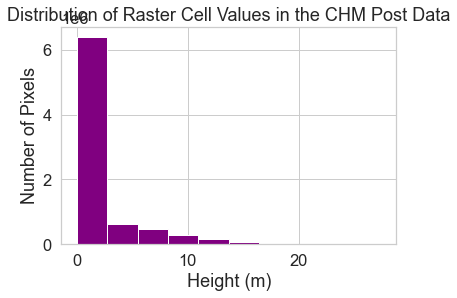

In [28]:
f, ax = plt.subplots()
post_lidar_chm.plot.hist(color="purple")
ax.set(title="Distribution of Raster Cell Values in the CHM Post Data",
       xlabel="Height (m)",
       ylabel="Number of Pixels")
plt.show()

In [30]:
changes_flood_ch = post_lidar_chm - pre_lidar_chm

In [39]:
# View min and max values in the data
print('changes_flood_ch min value:', np.nanmin(changes_flood_ch))
print('changes_flood_ch max value:', np.nanmax(changes_flood_ch))

changes_flood_ch min value: -23.429932
changes_flood_ch max value: 24.45996


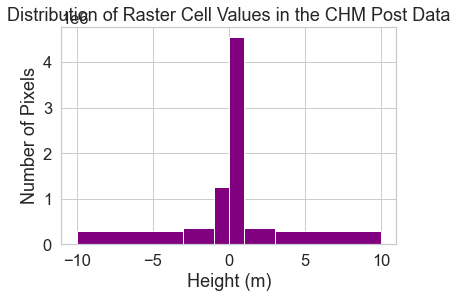

In [82]:
f, ax = plt.subplots()
changes_flood_ch.plot.hist(color="purple",
                          bins=[ -10, -3, -1, 0, 1, 3, 10])
ax.set(title="Distribution of Raster Cell Values in the CHM Post Data",
       xlabel="Height (m)",
       ylabel="Number of Pixels")
plt.show()

In [77]:
class_bins = [-np.inf, -3,  0, 3, np.inf]

changes_flood_ch_class = xr.apply_ufunc(np.digitize,
                                     changes_flood_ch,
                                     class_bins)

In [84]:
changes_flood_ch_class

<xarray.DataArray (y: 2000, x: 4000)>
array([[5, 5, 5, ..., 3, 2, 3],
       [5, 5, 5, ..., 3, 2, 2],
       [5, 5, 5, ..., 3, 3, 2],
       ...,
       [5, 5, 5, ..., 3, 3, 3],
       [5, 5, 5, ..., 3, 3, 3],
       [5, 5, 5, ..., 3, 3, 3]], dtype=int64)
Coordinates:
    band         int32 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int32 0

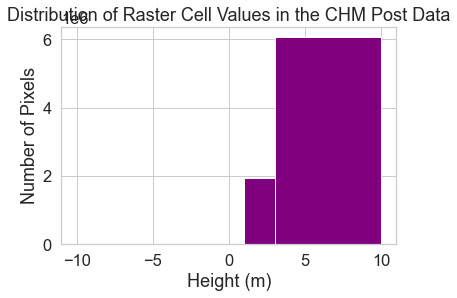

In [86]:
f, ax = plt.subplots()
changes_flood_ch_class.plot.hist(color="purple",
                          bins=[ -10, -3, -1, 0, 1, 3, 10])
ax.set(title="Distribution of Raster Cell Values in the CHM Post Data",
       xlabel="Height (m)",
       ylabel="Number of Pixels")
plt.show()

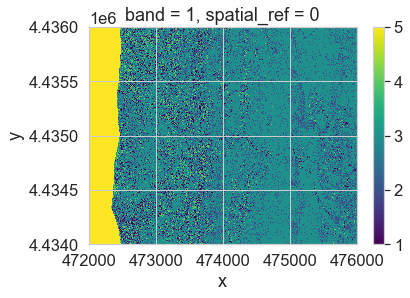

In [78]:
# Values of 7 represent missing data
im = changes_flood_ch_class.plot.imshow()
ax.set_axis_off()

In [83]:
# Mask out values not equalt to 5
changes_flood_ch_class_ma = changes_flood_ch_class.where(changes_flood_ch_class != 5)
changes_flood_ch_class_ma

<xarray.DataArray (y: 2000, x: 4000)>
array([[nan, nan, nan, ...,  3.,  2.,  3.],
       [nan, nan, nan, ...,  3.,  2.,  2.],
       [nan, nan, nan, ...,  3.,  3.,  2.],
       ...,
       [nan, nan, nan, ...,  3.,  3.,  3.],
       [nan, nan, nan, ...,  3.,  3.,  3.],
       [nan, nan, nan, ...,  3.,  3.,  3.]])
Coordinates:
    band         int32 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int32 0

In [107]:
path_to_tif_file = "C:/capes_sql/colorado-flood/outputs/changes_flood_ch_class_ma.tif"

# Write the data to a new geotiff file
changes_flood_ch_class_ma.rio.to_raster(path_to_tif_file)

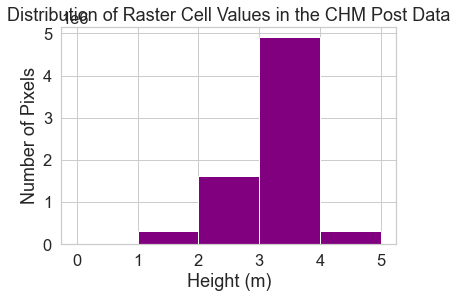

In [87]:
f, ax = plt.subplots()
changes_flood_ch_class_ma.plot.hist(color="purple",
                          bins=[ 0, 1, 2, 3 , 4, 5])
ax.set(title="Distribution of Raster Cell Values in the CHM Post Data",
       xlabel="Height (m)",
       ylabel="Number of Pixels")
plt.show()

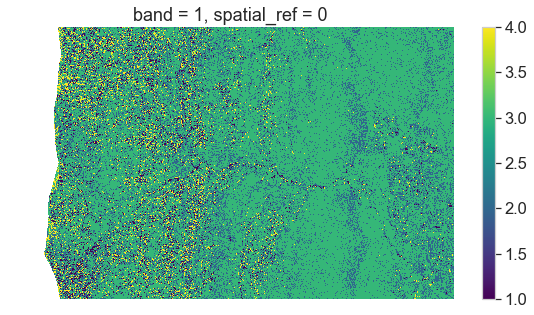

In [88]:
# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10,5))
changes_flood_ch_class_ma.plot.imshow(# Turn off colorbar
                                        #add_colorbar=False
)

ax.set_axis_off()
plt.show()

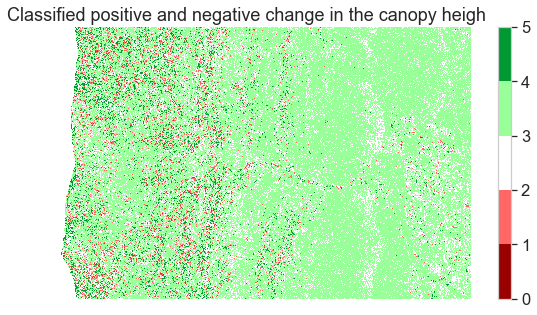

In [106]:
# Plot data using nicer colors
colors = ['#990000', '#ff6666', '#ffffff', '#99ff99', '#009933' ]
class_bins = [0, 1, 2, 3 , 4, 5]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 5))
changes_flood_ch_class_ma.plot.imshow(cmap=cmap,
                                   norm=norm) 
ax.set(title="Classified positive and negative change in the canopy heigh")
ax.set_axis_off()
plt.show()


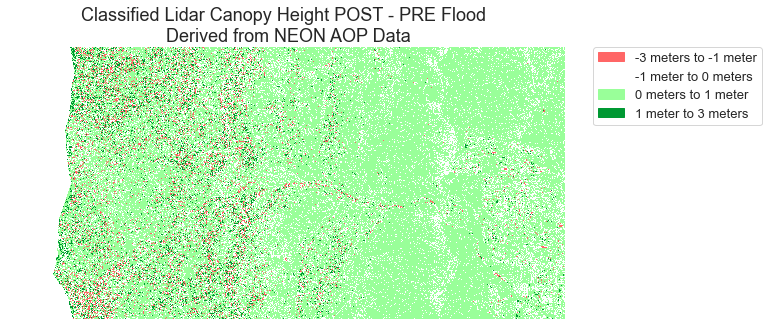

In [105]:
# Create a list of labels to use for your legend
height_class_labels = [
                       "-3 meters to -1 meter",
                       "-1 meter to 0 meters",
                       "0 meters to 1 meter",
                       "1 meter to 3 meters"                      
                      ]

cmap = ListedColormap(colors)
class_bins = [0, 1, 2, 3 , 4, 5]

norm = BoundaryNorm(class_bins,
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 5))
im = changes_flood_ch_class_ma.plot.imshow(cmap=cmap,
                                        norm=norm,
                                        # Turn off colorbar
                                        add_colorbar=False)
# Add legend using earthpy
ep.draw_legend(im,
               titles=height_class_labels)
ax.set(title="Classified Lidar Canopy Height POST - PRE Flood \n Derived from NEON AOP Data")
ax.set_axis_off()
plt.show()